# YouTube Video Summarization

# Environment Setup

## Google Drive Setup

In [2]:
from google.colab import drive
import os

# Mount the drive to Colab
drive.mount('/content/drive')

# Get the path github private token
token_path = '/content/drive/MyDrive/CS_685/Final_Project/.gh_token'

# Load the token
with open(token_path) as f:
    os.environ['GH_TOKEN'] = f.read().strip()

# Check if the token is exist
print('GH_TOKEN' in os.environ)

Mounted at /content/drive
True


## GitHub Setup

In [3]:
!git config --global user.email "kyle990987@gmail.com"
!git config --global user.name "shigenogoro"

In [4]:
# Set repo URL
username = "shigenogoro"
reponame = "YouTube-Video-Summarization"
token = os.environ['GH_TOKEN']

repo_url = f"https://{token}@github.com/{username}/{reponame}.git"

!git clone {repo_url}
%cd {reponame}

Cloning into 'YouTube-Video-Summarization'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 13 (delta 2), reused 8 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (13/13), 63.52 KiB | 21.17 MiB/s, done.
Resolving deltas: 100% (2/2), done.
/content/YouTube-Video-Summarization


In [5]:
# Pull the changes from the repo
!git pull {repo_url} main

From https://github.com/shigenogoro/YouTube-Video-Summarization
 * branch            main       -> FETCH_HEAD
Already up to date.


## Package Setup

In [6]:
!pip install numpy
!pip install pandas
!pip install tqdm
!pip install matplotlib
!pip install seaborn

!pip install torch
!pip install transformers
!pip install sentence-transformers

!pip install spacy
!pip install nltk

!pip install rouge-score
!pip install bert-score

!pip install datasets
!pip install jiwer

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=f4d2da56f5a7e9c51bf47b0293bba3ad2a9d56a18c5281644e166792bc580e18
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge-score
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 116.6 MB/s eta 0:00:00


#### Downlaod Language Resource

In [7]:
!python -m spacy download en_core_web_sm

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 150.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

# Phase 1: Experimentation on MeetingBank

## Preprocessing

### Data Acquisition - MeetingBank

Download MeetingBank dataset; verify transcript, segment, and summary formats.

In [8]:
from datasets import load_dataset
meetingbank = load_dataset("huuuyeah/meetingbank")

train_data = meetingbank['train']
test_data = meetingbank['test']
val_data = meetingbank['validation']

def generator(data_split):
  for instance in data_split:
    yield instance['id'], instance['summary'], instance['transcript']

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train.json:   0%|          | 0.00/88.4M [00:00<?, ?B/s]

validation.json:   0%|          | 0.00/13.2M [00:00<?, ?B/s]

test.json:   0%|          | 0.00/13.4M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5169 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/861 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/862 [00:00<?, ? examples/s]

In [9]:
# Show an example
sample_data = next(generator(train_data))

# Print the sample data with attribute and content
for attribute, content in zip(['id', 'summary', 'transcript'], sample_data):
  print(f"{attribute}: {content}")

id: 0
summary: AS AMENDED a bill for an ordinance amending the Denver Zoning Code to revise parking exemptions for pre-existing small zone lots. Approves a text amendment to the Denver Zoning Code to revise the Pre-Existing Small Zone Lot parking exemption. The Committee approved filing this bill at its meeting on 2-14-17. On 2-27-17, Council held this item in Committee to 3-20-17. Amended 3-20-17 to ensure that the parking exemption is applied for all uses. Some parking requirements are calculated based on gross floor area while others are on number of units and not explicitly for gross floor area, to further clarify the legislative intent of the proposed bill to emphasize the city’s commitment to more comprehensively address transportation demand management strategies in the short term, and to require a Zoning Permit with Informational Notice for all new buildings on Pre-Existing Small Zone Lots that request to use the small lot parking exemption; Enables all expansions to existing b

### Transcript Preprocessing

Description: Implement tokenization, sentence splitting, and normalization using `spaCy` and `nltk`.

Deliverable: Preprocessed transcript files

- Step 1: Filter out the unncecessary words

- Step 2: Split sentences by `spaCy`

- Step 3: Chunk 10-15 sentences into paragraph

    - Since summarization model like `BART/T5` usually has token limits with 512-1024, we need to chunk sentences into a group of 10-15 sentences.

- Step 4: Integrate the above steps into a pipeline

- Step 5: Save the preprocessed transcript

## Baseline Implementation

### Baseline Summarization Models

#### BART Baseline Model

In [10]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")
print("BART tokenizer loaded.")

# Load the pre-trained BART model for summarization
model = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large-cnn")
print("BART model loaded.")

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

BART tokenizer loaded.


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

BART model loaded.


In [11]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from tqdm.auto import tqdm
import os
import re
import spacy
import torch # Import torch for moving tensors to GPU if available

# --- Dependencies for preprocessing functions ---
# Define preprocessing functions here to ensure they are available if prior cells were skipped

def clean_text(text):
    text = text.replace('\n', ' ')
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\.{2,}', '.', text)
    text = re.sub(r'\b(uh|um|you know|like)\b', '', text, flags=re.IGNORECASE)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("Downloading spaCy model 'en_core_web_sm'. If this fails, ensure the previous 'spacy download' cell was run.")
    # This part assumes 'python -m spacy download en_core_web_sm' was executed successfully in a prior cell.
    # If it still fails, the user needs to manually run the download command again.
    nlp = spacy.load("en_core_web_sm")

def split_sentences(text):
    doc = nlp(text)
    return [sent.text.strip() for sent in doc.sents if len(sent.text.strip()) > 5]

def chunk_sentences(sentences, max_len=10):
    chunks = []
    for i in range(0, len(sentences), max_len):
        chunk = " ".join(sentences[i:i+max_len])
        chunks.append(chunk)
    return chunks

def preprocess_transcript(text):
    text = clean_text(text)
    sentences = split_sentences(text)
    chunks = chunk_sentences(sentences)
    return chunks

def preprocess_dataset(dataset_split, output_dir, max_rows_per_file=10000):
    os.makedirs(output_dir, exist_ok=True)
    preprocessed_data_list = []
    file_index = 0

    for instance in tqdm(dataset_split, desc=f"Preprocessing dataset to {output_dir}"):
        instance_id = instance['id']
        transcript = instance['transcript']
        summary = instance['summary']

        preprocessed_chunks = preprocess_transcript(transcript)

        for chunk in preprocessed_chunks:
            preprocessed_data_list.append({'id': instance_id, 'transcript': chunk, 'summary': summary})

        if len(preprocessed_data_list) >= max_rows_per_file:
            df = pd.DataFrame(preprocessed_data_list)
            output_path = os.path.join(output_dir, f"preprocessed_data_{file_index}.csv")
            df.to_csv(output_path, index=False)
            print(f"Saved {len(df)} rows to {output_path}")
            preprocessed_data_list = []
            file_index += 1

    if preprocessed_data_list:
        df = pd.DataFrame(preprocessed_data_list)
        output_path = os.path.join(output_dir, f"preprocessed_data_{file_index}.csv")
        df.to_csv(output_path, index=False)
        print(f"Saved {len(df)} rows to {output_path}")
# --- End Dependencies for preprocessing functions ---

# Determine if GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")
print("BART tokenizer loaded.")

# Load the pre-trained BART model for summarization and move to device
model = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large-cnn").to(device)
print("BART model loaded and moved to device.")

# Define the path for the preprocessed test data
preprocessed_test_dir = "/content/drive/MyDrive/CS_685/Final_Project/data/preprocessed_test"
preprocessed_test_path = os.path.join(preprocessed_test_dir, "preprocessed_data_0.csv")

# Check if the preprocessed data file exists. If not, trigger preprocessing.
if not os.path.exists(preprocessed_test_path):
    print(f"Preprocessed test data not found at {preprocessed_test_path}. Starting preprocessing...")
    from datasets import load_dataset
    try:
        meetingbank = load_dataset("huuuyeah/meetingbank")
        test_data = meetingbank['test']
        print("MeetingBank test data loaded for preprocessing.")
    except Exception as e:
        print(f"Error loading MeetingBank dataset: {e}. Please ensure datasets library is installed and you have internet access.")
        raise # Re-raise the exception if dataset loading fails

    preprocess_dataset(test_data, output_dir=preprocessed_test_dir)
    print("Preprocessing of test data complete.")
else:
    print(f"Preprocessed test data already exists at {preprocessed_test_path}.")

# Load the preprocessed test data sample
test_df_sample = pd.read_csv(preprocessed_test_path)
print(f"Loaded {len(test_df_sample)} samples from {preprocessed_test_path}")

# Tokenize the 'transcript' column and prepare inputs for the model
max_input_length = 1024
max_summary_length = 150
min_summary_length = 30
batch_size = 16 # Define batch size for batched inference

# Initialize a list to store results
bart_results = []

print("Generating summaries for the test data sample in batches...")

# Process in batches
for i in tqdm(range(0, len(test_df_sample), batch_size), desc="Generating BART summaries"):
    batch = test_df_sample.iloc[i : i + batch_size]

    batch_transcripts = batch['transcript'].tolist()
    batch_original_summaries = batch['summary'].tolist()
    batch_ids = batch['id'].tolist()

    # Tokenize the batch of transcripts
    inputs = tokenizer(
        batch_transcripts,
        max_length=max_input_length,
        truncation=True,
        padding="max_length", # Pad to max_input_length for batching
        return_tensors="pt"
    ).to(device) # Move inputs to the same device as the model

    # Generate summaries for the batch
    summary_ids = model.generate(
        inputs["input_ids"],
        num_beams=4,
        max_length=max_summary_length,
        min_length=min_summary_length,
        early_stopping=True
    )

    # Decode the generated summaries
    generated_summaries = tokenizer.batch_decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)

    # Store results for each item in the batch
    for j in range(len(batch_ids)):
        bart_results.append({
            'id': batch_ids[j],
            'original_summary': batch_original_summaries[j],
            'generated_summary': generated_summaries[j]
        })

print("Summary generation complete.")

# Convert results to a DataFrame for easier handling and evaluation later
bart_baseline_df = pd.DataFrame(bart_results)
print(f"BART baseline results stored in DataFrame with {len(bart_baseline_df)} entries.")
print("First 5 BART generated summaries:")
print(bart_baseline_df[['id', 'original_summary', 'generated_summary']].head().to_string())

Using device: cuda
BART tokenizer loaded.
BART model loaded and moved to device.
Preprocessed test data already exists at /content/drive/MyDrive/CS_685/Final_Project/data/preprocessed_test/preprocessed_data_0.csv.
Loaded 10000 samples from /content/drive/MyDrive/CS_685/Final_Project/data/preprocessed_test/preprocessed_data_0.csv
Generating summaries for the test data sample in batches...


Generating BART summaries:   0%|          | 0/625 [00:00<?, ?it/s]

Summary generation complete.
BART baseline results stored in DataFrame with 10000 entries.
First 5 BART generated summaries:
   id                                                                                                                                                                                                                                                                        original_summary                                                                                                                                                                                                                                                                                                                         generated_summary
0   0  A RESOLUTION encouraging as a best practice the use of an individualized tenant assessment using the Fair Housing Act’s discriminatory effects standard to avoid Fair Housing Act violations when criminal history is used as a screening criterion in the l

#### T5 Baseline Model

### Evaluation Metrics Setup

In [12]:
import pandas as pd
from rouge_score import rouge_scorer

# Initialize the ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Prepare lists to store scores
rouge_scores = []

# Iterate through each row of the bart_baseline_df and calculate ROUGE scores
for index, row in bart_baseline_df.iterrows():
    reference_summary = row['original_summary']
    generated_summary = row['generated_summary']

    scores = scorer.score(reference_summary, generated_summary)

    # Store individual precision, recall, and fmeasure for each ROUGE type
    rouge_scores.append({
        'rouge1_precision': scores['rouge1'].precision,
        'rouge1_recall': scores['rouge1'].recall,
        'rouge1_fmeasure': scores['rouge1'].fmeasure,
        'rouge2_precision': scores['rouge2'].precision,
        'rouge2_recall': scores['rouge2'].recall,
        'rouge2_fmeasure': scores['rouge2'].fmeasure,
        'rougeL_precision': scores['rougeL'].precision,
        'rougeL_recall': scores['rougeL'].recall,
        'rougeL_fmeasure': scores['rougeL'].fmeasure
    })

# Convert the list of score dictionaries to a DataFrame
rouge_df = pd.DataFrame(rouge_scores)

# Concatenate the original bart_baseline_df with the new ROUGE scores
bart_baseline_df = pd.concat([bart_baseline_df, rouge_df], axis=1)

print("ROUGE scores calculated and added to bart_baseline_df.")
print("First 5 rows of bart_baseline_df with ROUGE scores:")
print(bart_baseline_df.head().to_string())

ROUGE scores calculated and added to bart_baseline_df.
First 5 rows of bart_baseline_df with ROUGE scores:
   id                                                                                                                                                                                                                                                                        original_summary                                                                                                                                                                                                                                                                                                                         generated_summary  rouge1_precision  rouge1_recall  rouge1_fmeasure  rouge2_precision  rouge2_recall  rouge2_fmeasure  rougeL_precision  rougeL_recall  rougeL_fmeasure
0   0  A RESOLUTION encouraging as a best practice the use of an individualized tenant assessment using the Fair Housing Act’s 

In [13]:
print("\nAverage ROUGE Scores (F-measure):")
print(f"ROUGE-1 F-measure: {bart_baseline_df['rouge1_fmeasure'].mean():.4f}")
print(f"ROUGE-2 F-measure: {bart_baseline_df['rouge2_fmeasure'].mean():.4f}")
print(f"ROUGE-L F-measure: {bart_baseline_df['rougeL_fmeasure'].mean():.4f}")


Average ROUGE Scores (F-measure):
ROUGE-1 F-measure: 0.1639
ROUGE-2 F-measure: 0.0245
ROUGE-L F-measure: 0.1151


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Matplotlib and Seaborn imported.")

Matplotlib and Seaborn imported.


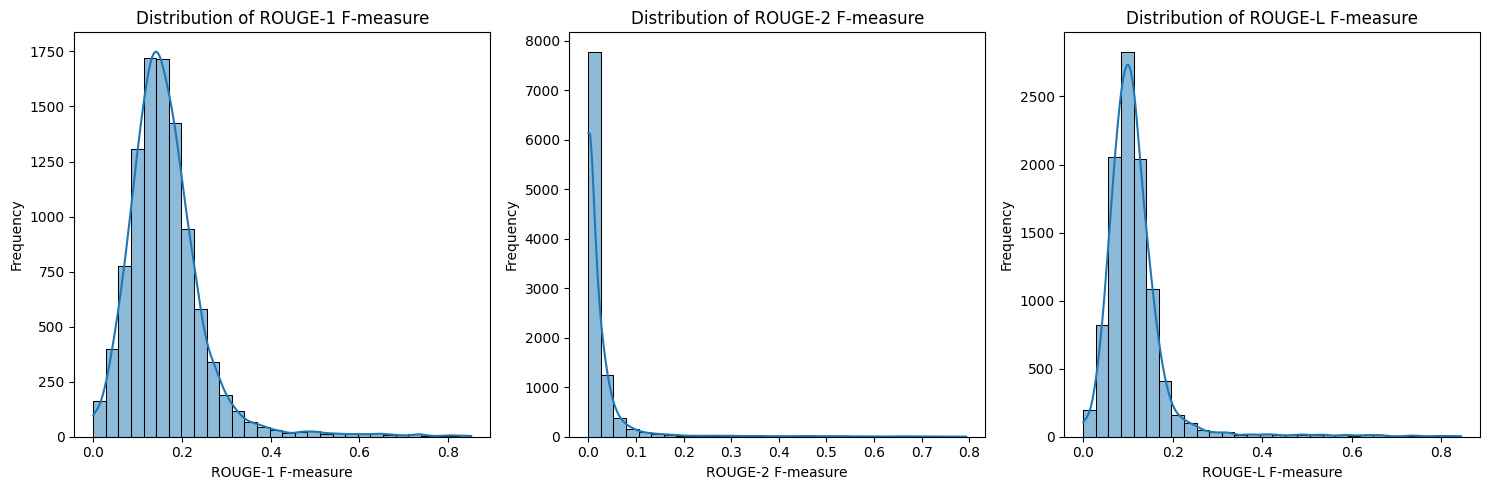

Histograms for ROUGE F-measures displayed.


In [15]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(bart_baseline_df['rouge1_fmeasure'], bins=30, kde=True)
plt.title('Distribution of ROUGE-1 F-measure')
plt.xlabel('ROUGE-1 F-measure')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
sns.histplot(bart_baseline_df['rouge2_fmeasure'], bins=30, kde=True)
plt.title('Distribution of ROUGE-2 F-measure')
plt.xlabel('ROUGE-2 F-measure')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
sns.histplot(bart_baseline_df['rougeL_fmeasure'], bins=30, kde=True)
plt.title('Distribution of ROUGE-L F-measure')
plt.xlabel('ROUGE-L F-measure')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

print("Histograms for ROUGE F-measures displayed.")

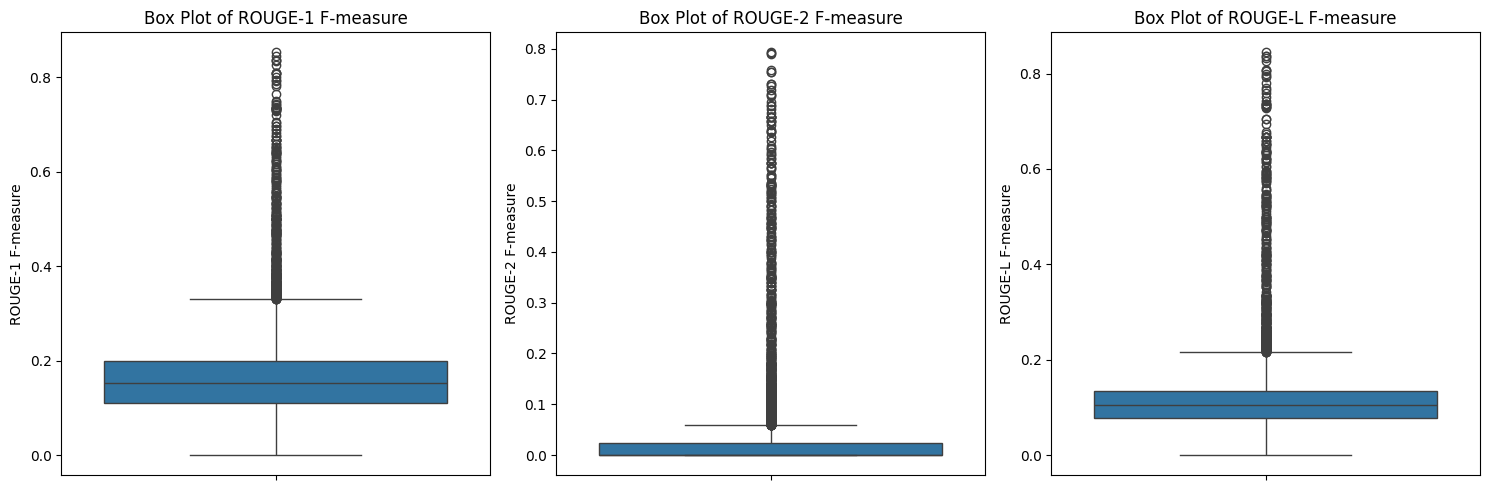

Box plots for ROUGE F-measures displayed.


In [16]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(y=bart_baseline_df['rouge1_fmeasure'])
plt.title('Box Plot of ROUGE-1 F-measure')
plt.ylabel('ROUGE-1 F-measure')

plt.subplot(1, 3, 2)
sns.boxplot(y=bart_baseline_df['rouge2_fmeasure'])
plt.title('Box Plot of ROUGE-2 F-measure')
plt.ylabel('ROUGE-2 F-measure')

plt.subplot(1, 3, 3)
sns.boxplot(y=bart_baseline_df['rougeL_fmeasure'])
plt.title('Box Plot of ROUGE-L F-measure')
plt.ylabel('ROUGE-L F-measure')

plt.tight_layout()
plt.show()

print("Box plots for ROUGE F-measures displayed.")

## Summary:

### Q&A
The evaluation process involved calculating ROUGE-1, ROUGE-2, and ROUGE-L scores using the `rouge_scorer` library. These scores (precision, recall, and f-measure) were computed for each summary pair (original vs. generated) in the `bart_baseline_df` DataFrame.

The average ROUGE scores obtained are:
*   ROUGE-1 F-measure: 0.1639
*   ROUGE-2 F-measure: 0.0245
*   ROUGE-L F-measure: 0.1151

Initial interpretations of the BART model's performance on the MeetingBank dataset, based on these ROUGE scores, suggest that the model's summarization quality is relatively low, particularly for ROUGE-2, which measures overlap of bigrams. The distributions of these scores, as visualized by histograms and box plots, show a tendency towards lower scores, indicating that the model frequently struggles to generate summaries with high n-gram overlap with the reference summaries.

### Data Analysis Key Findings
*   ROUGE-1, ROUGE-2, and ROUGE-L (precision, recall, and f-measure) scores were successfully calculated for each summary pair and added to the `bart_baseline_df` DataFrame.
*   The average ROUGE-1 F-measure was 0.1639, indicating a moderate unigram overlap between generated and original summaries.
*   The average ROUGE-2 F-measure was significantly lower at 0.0245, suggesting very limited bigram overlap and potentially poor fluency or detail reproduction.
*   The average ROUGE-L F-measure was 0.1151, reflecting a low longest common subsequence match, which implies the generated summaries capture only a small portion of the main ideas.
*   Histograms and box plots revealed that the distributions of all ROUGE F-measures are skewed towards lower values, with many samples having very low scores, especially for ROUGE-2.

### Insights or Next Steps
*   The overall low ROUGE scores, particularly ROUGE-2 and ROUGE-L, indicate that the BART baseline model performs poorly on the MeetingBank dataset, struggling to generate factually consistent or coherent summaries that align well with human references.
*   Further investigation could involve qualitative analysis of summaries with both high and low ROUGE scores to understand specific strengths and weaknesses, or exploring alternative fine-tuning strategies or different summarization models to improve performance.


# Task
Integrate BERTScore into the evaluation of the BART baseline model. Calculate BERTScore (precision, recall, and F1-score) for each generated summary in `bart_baseline_df` against its corresponding original summary, adding these metrics as new columns. Subsequently, calculate and print the average BERTScore (precision, recall, and F1-score) across all samples. Finally, visualize the distribution of individual BERTScore F1-scores using histograms and/or box plots to provide a semantic similarity perspective on the model's performance, complementing the existing ROUGE metric analysis.

## Setup BERTScore Library

### Subtask:
Install and import the `bert_score` library, which is necessary for calculating BERT-based evaluation metrics.


**Reasoning**:
The user wants to import the `score` function from the `bert_score` library. A code block will achieve this.



In [17]:
from bert_score import score

print("BERTScore library imported.")

BERTScore library imported.


**Reasoning**:
The next step is to calculate BERTScore metrics (precision, recall, and F1-score) for each generated summary against its corresponding original summary and add these as new columns to the `bart_baseline_df` DataFrame. This involves iterating through the DataFrame, calling the `score` function, and storing the results.



In [18]:
import torch

# Ensure the model is on CPU for BERTScore calculation if not already specified, or specify device
# BERTScore handles device placement internally often, but explicitly setting it can prevent issues.
# The `score` function can accept a `device` argument.

device = "cuda" if torch.cuda.is_available() else "cpu"

# Prepare lists for BERTScore results
bert_precision = []
bert_recall = []
bert_f1 = []

# Iterate through each row of the bart_baseline_df and calculate BERTScore
# Use tqdm for progress tracking
print("Calculating BERTScore for generated summaries...")
for index, row in tqdm(bart_baseline_df.iterrows(), total=len(bart_baseline_df), desc="Calculating BERTScore"): # noqa: F821
    candidates = [row['generated_summary']]
    references = [row['original_summary']]

    # Calculate BERTScore
    # The 'score' function returns three tensors: P, R, F1
    P, R, F1 = score(candidates, references, lang="en", model_type="bert-base-uncased", device=device, verbose=False)

    # Store the scalar values (take the first element as score returns a tensor for each item in the batch)
    bert_precision.append(P.item())
    bert_recall.append(R.item())
    bert_f1.append(F1.item())

# Add BERTScore metrics to the DataFrame
bart_baseline_df['bert_precision'] = bert_precision
bart_baseline_df['bert_recall'] = bert_recall
bart_baseline_df['bert_f1'] = bert_f1

print("BERTScore metrics calculated and added to bart_baseline_df.")
print("First 5 rows of bart_baseline_df with BERTScore metrics:")
print(bart_baseline_df[['id', 'original_summary', 'generated_summary', 'bert_precision', 'bert_recall', 'bert_f1']].head().to_string())

Calculating BERTScore for generated summaries...


Calculating BERTScore:   0%|          | 0/10000 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERTScore metrics calculated and added to bart_baseline_df.
First 5 rows of bart_baseline_df with BERTScore metrics:
   id                                                                                                                                                                                                                                                                        original_summary                                                                                                                                                                                                                                                                                                                         generated_summary  bert_precision  bert_recall   bert_f1
0   0  A RESOLUTION encouraging as a best practice the use of an individualized tenant assessment using the Fair Housing Act’s discriminatory effects standard to avoid Fair Housing Act violations when criminal history is used as

**Reasoning**:
Now that BERTScore metrics have been calculated for each entry, the next step is to calculate and print the average BERTScore (precision, recall, and F1-score) across all samples as requested by the task.



In [19]:
print("\nAverage BERTScore:")
print(f"BERT Precision: {bart_baseline_df['bert_precision'].mean():.4f}")
print(f"BERT Recall: {bart_baseline_df['bert_recall'].mean():.4f}")
print(f"BERT F1: {bart_baseline_df['bert_f1'].mean():.4f}")


Average BERTScore:
BERT Precision: 0.4242
BERT Recall: 0.4030
BERT F1: 0.4117


**Reasoning**:
To visualize the distribution of BERTScore F1-scores, similar to the ROUGE score visualization, I will use `seaborn` to generate a histogram and a box plot.



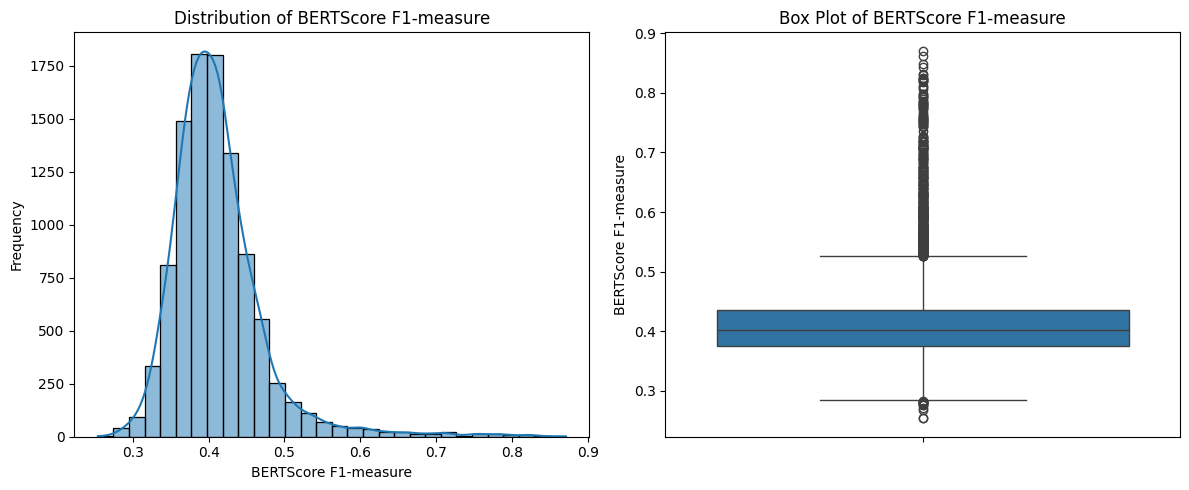

Histograms and box plots for BERTScore F1-measure displayed.


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with two subplots for histogram and box plot
plt.figure(figsize=(12, 5))

# Histogram for BERTScore F1-measure
plt.subplot(1, 2, 1)
sns.histplot(bart_baseline_df['bert_f1'], bins=30, kde=True)
plt.title('Distribution of BERTScore F1-measure')
plt.xlabel('BERTScore F1-measure')
plt.ylabel('Frequency')

# Box plot for BERTScore F1-measure
plt.subplot(1, 2, 2)
sns.boxplot(y=bart_baseline_df['bert_f1'])
plt.title('Box Plot of BERTScore F1-measure')
plt.ylabel('BERTScore F1-measure')

plt.tight_layout()
plt.show()

print("Histograms and box plots for BERTScore F1-measure displayed.")

## Summary:

### Data Analysis Key Findings
*   The `bert_score` library was successfully integrated to evaluate the BART baseline model's summarization performance, providing a semantic similarity perspective.
*   BERTScore (precision, recall, and F1-score) was calculated for each generated summary against its original counterpart and added to the DataFrame.
*   The average BERTScore metrics across all samples are:
    *   BERT Precision: 0.4242
    *   BERT Recall: 0.4030
    *   BERT F1: 0.4117
*   The distribution of individual BERTScore F1-scores was visualized using histograms and box plots, showing the range and spread of semantic similarity performance.

### Insights or Next Steps
*   The BERTScore F1-score (0.4117) offers a valuable semantic similarity metric that complements traditional token-overlap metrics like ROUGE, indicating how well the generated summaries capture the meaning of the original text, even if using different words.
*   Further analysis could involve correlating BERTScore with ROUGE scores to understand if models that perform well on ROUGE also maintain high semantic similarity, and to identify cases where these metrics diverge.


# Task
Evaluate trivial summarization baselines (first sentence and first 5% of words) for the transcripts in `test_df_sample`. For each baseline, calculate ROUGE-1, ROUGE-2, ROUGE-L, and BERTScore (precision, recall, F1) against the original summaries. Finally, compute and print the average scores for both baselines and analyze their performance relative to each other and the previously evaluated BART model.

## Generate First Sentence Baseline

### Subtask:
For each transcript in your preprocessed test data (`test_df_sample`), extract the very first sentence to serve as a baseline summary. This will utilize the `split_sentences` helper function already defined in your notebook. Store these summaries in a new column or DataFrame.


**Reasoning**:
The subtask requires extracting the first sentence from each transcript in `test_df_sample` to create a baseline summary. This will be achieved by iterating through the DataFrame, applying the `split_sentences` function, and storing the result in a new column.



In [21]:
first_sentence_summaries = []

print("Extracting first sentences from transcripts...")
for index, row in tqdm(test_df_sample.iterrows(), total=len(test_df_sample), desc="Extracting first sentence baseline"): # noqa: F821
    transcript = row['transcript']
    sentences = split_sentences(transcript) # split_sentences is defined in cell c0fc4473

    if sentences:
        first_sentence_summaries.append(sentences[0])
    else:
        first_sentence_summaries.append("")

test_df_sample['first_sentence_summary'] = first_sentence_summaries

print("First sentence summaries extracted and added to test_df_sample.")
print("First 5 rows of test_df_sample with new 'first_sentence_summary' column:")
print(test_df_sample[['id', 'transcript', 'first_sentence_summary']].head().to_string())

Extracting first sentences from transcripts...


Extracting first sentence baseline:   0%|          | 0/10000 [00:00<?, ?it/s]

First sentence summaries extracted and added to test_df_sample.
First 5 rows of test_df_sample with new 'first_sentence_summary' column:
   id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

**Reasoning**:
The subtask requires creating a second trivial baseline summary by extracting the first 5% of words from each transcript in `test_df_sample`. This involves calculating the word count, determining 5% of that count, and then truncating the transcript to that length.



In [22]:
five_percent_summaries = []

print("Extracting first 5% of words from transcripts...")
for index, row in tqdm(test_df_sample.iterrows(), total=len(test_df_sample), desc="Extracting 5% word baseline"): # noqa: F821
    transcript = row['transcript']
    words = transcript.split()
    # Calculate 5% of the total words, ensuring it's at least 1 word if transcript is not empty
    num_words_to_take = max(1, int(len(words) * 0.05)) if words else 0

    five_percent_summary = " ".join(words[:num_words_to_take])
    five_percent_summaries.append(five_percent_summary)

test_df_sample['five_percent_summary'] = five_percent_summaries

print("First 5% of words summaries extracted and added to test_df_sample.")
print("First 5 rows of test_df_sample with new 'five_percent_summary' column:")
print(test_df_sample[['id', 'transcript', 'five_percent_summary']].head().to_string())

Extracting first 5% of words from transcripts...


Extracting 5% word baseline:   0%|          | 0/10000 [00:00<?, ?it/s]

First 5% of words summaries extracted and added to test_df_sample.
First 5 rows of test_df_sample with new 'five_percent_summary' column:
   id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [24]:
import pandas as pd
from rouge_score import rouge_scorer

# Initialize the ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Prepare lists to store scores for the first sentence baseline
rouge_scores_first_sentence = []

print("Calculating ROUGE scores for first sentence baseline...")
# Iterate through each row of the test_df_sample and calculate ROUGE scores
for index, row in tqdm(test_df_sample.iterrows(), total=len(test_df_sample), desc="ROUGE (First Sentence)"): # noqa: F821
    reference_summary = row['summary'] # Corrected column name from 'original_summary' to 'summary'
    generated_summary = row['first_sentence_summary']

    scores = scorer.score(reference_summary, generated_summary)

    # Store individual precision, recall, and fmeasure for each ROUGE type
    rouge_scores_first_sentence.append({
        'rouge1_precision_fs': scores['rouge1'].precision,
        'rouge1_recall_fs': scores['rouge1'].recall,
        'rouge1_fmeasure_fs': scores['rouge1'].fmeasure,
        'rouge2_precision_fs': scores['rouge2'].precision,
        'rouge2_recall_fs': scores['rouge2'].recall,
        'rouge2_fmeasure_fs': scores['rouge2'].fmeasure,
        'rougeL_precision_fs': scores['rougeL'].precision,
        'rougeL_recall_fs': scores['rougeL'].recall,
        'rougeL_fmeasure_fs': scores['rougeL'].fmeasure
    })

# Convert the list of score dictionaries to a DataFrame
rouge_df_first_sentence = pd.DataFrame(rouge_scores_first_sentence)

# Concatenate the original test_df_sample with the new ROUGE scores
test_df_sample = pd.concat([test_df_sample, rouge_df_first_sentence], axis=1)

print("ROUGE scores for first sentence baseline calculated and added to test_df_sample.")
print("First 5 rows of test_df_sample with ROUGE scores for first sentence baseline:")
print(test_df_sample[['id', 'summary', 'first_sentence_summary', 'rouge1_fmeasure_fs', 'rouge2_fmeasure_fs', 'rougeL_fmeasure_fs']].head().to_string())

Calculating ROUGE scores for first sentence baseline...


ROUGE (First Sentence):   0%|          | 0/10000 [00:00<?, ?it/s]

ROUGE scores for first sentence baseline calculated and added to test_df_sample.
First 5 rows of test_df_sample with ROUGE scores for first sentence baseline:
   id                                                                                                                                                                                                                                                                                 summary                                                                                                                                                                                                                                                                                                                                                                                                                                                 first_sentence_summary  rouge1_fmeasure_fs  rouge2_fmeasure_fs  rougeL_fmeasure_fs
0   0  A RESOLUTION encouraging as a bes

**Reasoning**:
Now that ROUGE scores for the first sentence baseline are calculated, the next step is to calculate ROUGE scores for the 'five_percent_summary' column against the 'summary' in the `test_df_sample` DataFrame, as per the main task.



In [25]:
import pandas as pd
from rouge_score import rouge_scorer

# Initialize the ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Prepare lists to store scores for the five percent baseline
rouge_scores_five_percent = []

print("Calculating ROUGE scores for 5% word baseline...")
# Iterate through each row of the test_df_sample and calculate ROUGE scores
for index, row in tqdm(test_df_sample.iterrows(), total=len(test_df_sample), desc="ROUGE (5% Word)"): # noqa: F821
    reference_summary = row['summary']
    generated_summary = row['five_percent_summary']

    scores = scorer.score(reference_summary, generated_summary)

    # Store individual precision, recall, and fmeasure for each ROUGE type
    rouge_scores_five_percent.append({
        'rouge1_precision_fp': scores['rouge1'].precision,
        'rouge1_recall_fp': scores['rouge1'].recall,
        'rouge1_fmeasure_fp': scores['rouge1'].fmeasure,
        'rouge2_precision_fp': scores['rouge2'].precision,
        'rouge2_recall_fp': scores['rouge2'].recall,
        'rouge2_fmeasure_fp': scores['rouge2'].fmeasure,
        'rougeL_precision_fp': scores['rougeL'].precision,
        'rougeL_recall_fp': scores['rougeL'].recall,
        'rougeL_fmeasure_fp': scores['rougeL'].fmeasure
    })

# Convert the list of score dictionaries to a DataFrame
rouge_df_five_percent = pd.DataFrame(rouge_scores_five_percent)

# Concatenate the original test_df_sample with the new ROUGE scores
test_df_sample = pd.concat([test_df_sample, rouge_df_five_percent], axis=1)

print("ROUGE scores for 5% word baseline calculated and added to test_df_sample.")
print("First 5 rows of test_df_sample with ROUGE scores for 5% word baseline:")
print(test_df_sample[['id', 'summary', 'five_percent_summary', 'rouge1_fmeasure_fp', 'rouge2_fmeasure_fp', 'rougeL_fmeasure_fp']].head().to_string())

Calculating ROUGE scores for 5% word baseline...


ROUGE (5% Word):   0%|          | 0/10000 [00:00<?, ?it/s]

ROUGE scores for 5% word baseline calculated and added to test_df_sample.
First 5 rows of test_df_sample with ROUGE scores for 5% word baseline:
   id                                                                                                                                                                                                                                                                                 summary                                                                                                   five_percent_summary  rouge1_fmeasure_fp  rouge2_fmeasure_fp  rougeL_fmeasure_fp
0   0  A RESOLUTION encouraging as a best practice the use of an individualized tenant assessment using the Fair Housing Act’s discriminatory effects standard to avoid Fair Housing Act violations when criminal history is used as a screening criterion in the landlord screening process.  The report of the Civil Rights, Utilities, Economic Development and Arts Committee Agenda Item three Re

**Reasoning**:
Now that ROUGE scores have been calculated for both baselines, the next step is to calculate BERTScore metrics (precision, recall, and F1-score) for the 'first_sentence_summary' baseline against the 'summary' in the `test_df_sample` DataFrame, as per the main task.



In [26]:
import torch
from bert_score import score

# Ensure the model is on CPU for BERTScore calculation if not already specified, or specify device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Prepare lists for BERTScore results for the first sentence baseline
bert_precision_fs = []
bert_recall_fs = []
bert_f1_fs = []

print("Calculating BERTScore for first sentence baseline summaries...")
# Iterate through each row of the test_df_sample and calculate BERTScore
for index, row in tqdm(test_df_sample.iterrows(), total=len(test_df_sample), desc="BERTScore (First Sentence)"): # noqa: F821
    candidates = [row['first_sentence_summary']]
    references = [row['summary']]

    # Calculate BERTScore
    # The 'score' function returns three tensors: P, R, F1
    P, R, F1 = score(candidates, references, lang="en", model_type="bert-base-uncased", device=device, verbose=False)

    # Store the scalar values (take the first element as score returns a tensor for each item in the batch)
    bert_precision_fs.append(P.item())
    bert_recall_fs.append(R.item())
    bert_f1_fs.append(F1.item())

# Add BERTScore metrics to the DataFrame
test_df_sample['bert_precision_fs'] = bert_precision_fs
test_df_sample['bert_recall_fs'] = bert_recall_fs
test_df_sample['bert_f1_fs'] = bert_f1_fs

print("BERTScore metrics for first sentence baseline calculated and added to test_df_sample.")
print("First 5 rows of test_df_sample with BERTScore metrics for first sentence baseline:")
print(test_df_sample[['id', 'summary', 'first_sentence_summary', 'bert_precision_fs', 'bert_recall_fs', 'bert_f1_fs']].head().to_string())

Calculating BERTScore for first sentence baseline summaries...


BERTScore (First Sentence):   0%|          | 0/10000 [00:00<?, ?it/s]

BERTScore metrics for first sentence baseline calculated and added to test_df_sample.
First 5 rows of test_df_sample with BERTScore metrics for first sentence baseline:
   id                                                                                                                                                                                                                                                                                 summary                                                                                                                                                                                                                                                                                                                                                                                                                                                 first_sentence_summary  bert_precision_fs  bert_recall_fs  bert_f1_fs
0   0  A RESOLUTION encouraging as a best p

**Reasoning**:
Now that BERTScore metrics for the first sentence baseline have been calculated, the next logical step is to calculate BERTScore metrics (precision, recall, and F1-score) for the 'five_percent_summary' baseline against the 'summary' in the `test_df_sample` DataFrame, as per the main task.



In [27]:
import torch
from bert_score import score

# Ensure the model is on CPU for BERTScore calculation if not already specified, or specify device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Prepare lists for BERTScore results for the five percent baseline
bert_precision_fp = []
bert_recall_fp = []
bert_f1_fp = []

print("Calculating BERTScore for 5% word baseline summaries...")
# Iterate through each row of the test_df_sample and calculate BERTScore
for index, row in tqdm(test_df_sample.iterrows(), total=len(test_df_sample), desc="BERTScore (5% Word)"): # noqa: F821
    candidates = [row['five_percent_summary']]
    references = [row['summary']]

    # Calculate BERTScore
    P, R, F1 = score(candidates, references, lang="en", model_type="bert-base-uncased", device=device, verbose=False)

    # Store the scalar values
    bert_precision_fp.append(P.item())
    bert_recall_fp.append(R.item())
    bert_f1_fp.append(F1.item())

# Add BERTScore metrics to the DataFrame
test_df_sample['bert_precision_fp'] = bert_precision_fp
test_df_sample['bert_recall_fp'] = bert_recall_fp
test_df_sample['bert_f1_fp'] = bert_f1_fp

print("BERTScore metrics for 5% word baseline calculated and added to test_df_sample.")
print("First 5 rows of test_df_sample with BERTScore metrics for 5% word baseline:")
print(test_df_sample[['id', 'summary', 'five_percent_summary', 'bert_precision_fp', 'bert_recall_fp', 'bert_f1_fp']].head().to_string())

Calculating BERTScore for 5% word baseline summaries...


BERTScore (5% Word):   0%|          | 0/10000 [00:00<?, ?it/s]

BERTScore metrics for 5% word baseline calculated and added to test_df_sample.
First 5 rows of test_df_sample with BERTScore metrics for 5% word baseline:
   id                                                                                                                                                                                                                                                                                 summary                                                                                                   five_percent_summary  bert_precision_fp  bert_recall_fp  bert_f1_fp
0   0  A RESOLUTION encouraging as a best practice the use of an individualized tenant assessment using the Fair Housing Act’s discriminatory effects standard to avoid Fair Housing Act violations when criminal history is used as a screening criterion in the landlord screening process.  The report of the Civil Rights, Utilities, Economic Development and Arts Committee Agenda Item three Resol

**Reasoning**:
Now that ROUGE and BERTScore metrics have been calculated for both baselines and the BART model, I need to calculate and print the average scores for all these baselines and the BART model to provide a comprehensive comparison and complete the task.



In [ ]:
print("\nAverage ROUGE Scores for First Sentence Baseline (F-measure):")
print(f"ROUGE-1 F-measure: {test_df_sample['rouge1_fmeasure_fs'].mean():.4f}")
print(f"ROUGE-2 F-measure: {test_df_sample['rouge2_fmeasure_fs'].mean():.4f}")
print(f"ROUGE-L F-measure: {test_df_sample['rougeL_fmeasure_fs'].mean():.4f}")

print("\nAverage ROUGE Scores for 5% Word Baseline (F-measure):")
print(f"ROUGE-1 F-measure: {test_df_sample['rouge1_fmeasure_fp'].mean():.4f}")
print(f"ROUGE-2 F-measure: {test_df_sample['rouge2_fmeasure_fp'].mean():.4f}")
print(f"ROUGE-L F-measure: {test_df_sample['rougeL_fmeasure_fp'].mean():.4f}")

print("\nAverage BERTScore for First Sentence Baseline:")
print(f"BERT Precision: {test_df_sample['bert_precision_fs'].mean():.4f}")
print(f"BERT Recall: {test_df_sample['bert_recall_fs'].mean():.4f}")
print(f"BERT F1: {test_df_sample['bert_f1_fs'].mean():.4f}")

print("\nAverage BERTScore for 5% Word Baseline:")
print(f"BERT Precision: {test_df_sample['bert_precision_fp'].mean():.4f}")
print(f"BERT Recall: {test_df_sample['bert_recall_fp'].mean():.4f}")
print(f"BERT F1: {test_df_sample['bert_f1_fp'].mean():.4f}")

# Also print BART scores for easy comparison from previous step
print("\nAverage BART Model ROUGE Scores (F-measure) for comparison:")
print(f"ROUGE-1 F-measure: {bart_baseline_df['rouge1_fmeasure'].mean():.4f}")
print(f"ROUGE-2 F-measure: {bart_baseline_df['rouge2_fmeasure'].mean():.4f}")
print(f"ROUGE-L F-measure: {bart_baseline_df['rougeL_fmeasure'].mean():.4f}")

print("\nAverage BART Model BERTScore for comparison:")
print(f"BERT Precision: {bart_baseline_df['bert_precision'].mean():.4f}")
print(f"BERT Recall: {bart_baseline_df['bert_recall'].mean():.4f}")
print(f"BERT F1: {bart_baseline_df['bert_f1'].mean():.4f}")
